In [1]:
# WRITTEN BY ALAN LI
# NASA AMES LABORATORY FOR ADVANCED SENSING (LAS)
# Last edited: April 26, 2018
%matplotlib notebook

import sys
sys.path.append("./utils/") # Adds higher directory to python modules path.
import random
import numpy as np
import pydensecrf.densecrf as dcrf
import cv2
import glob, os
from collections import Counter

from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import colors
from collections import Counter
import logging
import yaml
import json
from PIL import Image as pil_image
from osgeo import gdal, ogr, osr

import tensorflow as tf
from tensorflow.python.client import device_lib
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

import loadcoraldata_utils as coralutils
import keras
import keras.backend as K
from keras.models import Model, Sequential, load_model
from keras.utils import np_utils
from keras import optimizers
from keras.preprocessing.image import img_to_array
from keras.callbacks import Callback
from keras.utils.np_utils import to_categorical
from NeMO_models import FCN
from NeMO_losses import charbonnierLoss
import NeMO_layers
import NeMO_encoders
from NeMO_generator import NeMOImageGenerator, ImageSetLoader
from NeMO_callbacks import CheckNumericsOps, WeightsSaver

num_cores = 4
num_GPU = 1
num_CPU = 1

global _SESSION
config = tf.ConfigProto(intra_op_parallelism_threads=num_cores,
        inter_op_parallelism_threads=num_cores, allow_soft_placement=True,
        device_count = {'CPU' : num_CPU, 'GPU' : num_GPU})
_SESSION = tf.Session(config=config)
K.set_session(_SESSION)

%matplotlib notebook

model = load_model('./tmp/RefineMask_Jarrett256_RGB_NIR_spectralshift.h5', custom_objects={'BilinearUpSampling2D':NeMO_layers.BilinearUpSampling2D, 'charbonnierLoss': charbonnierLoss})
# cloudmodel = load_model('./tmp/RefineMask_Cloud.h5', custom_objects={'BilinearUpSampling2D':NeMO_layers.BilinearUpSampling2D, 'charbonnierLoss': charbonnierLoss})

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Using TensorFlow backend.


Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [82]:
# Test export of patches from gdal
imgpath = '/home/shared/NeMO-Net Data/processed_Fiji_files/mosaiced_003.TIF'
imgpath_original = '/home/shared/NeMO-Net Data/KSLOF-CICIA-FIJI/Cicia_Satellite_image_mosaic_KSLOF.tif'
truthpath = '/home/shared/NeMO-Net Data/KSLOF-CICIA-FIJI/Cicia_Habitat_classes_raster_KSLOF.tif'
# imgpath = '/home/shared/NeMO-Net Data/processed_Fiji_files/mosaiced_004.TIF'
# imgpath_original = '/home/shared/NeMO-Net Data/KSLOF-FULAGA_Fiji/Fulaga_Satellite_image_mosaic_KSLOF.tif'
# truthpath = '/home/shared/NeMO-Net Data/KSLOF-FULAGA_Fiji/Fulaga_Habitat_classes_raster_KSLOF.tif'

output_trainpath = '../Images/Fiji_Training_Patches/'
output_trainrefpath = '../Images/Fiji_TrainingRef_Patches/'
output_trainfilename = 'rastertrain.txt'
output_validpath = '../Images/Fiji_Valid_Patches/'
output_validrefpath = '../Images/Fiji_ValidRef_Patches/'
output_validfilename = 'rastervalid.txt'
jsonpath = './utils/CoralClasses.json'

with open(jsonpath) as json_file:
    json_data = json.load(json_file)

Fiji = coralutils.CoralData(imgpath, Truthpath=truthpath, truth_key=json_data["Fiji_ClassDict"], load_type="raster")
Fiji.Consolidate_classes(newclassdict=json_data["L3_ClassDict"], transferdict=json_data["Fiji2L3_Dict"])
FijiTruth_24classes = np.copy(Fiji.truthimage_consolidated)
Fiji.Consolidate_classes(newclassdict=json_data["VedConsolidated_ClassDict"], transferdict=json_data["L32VedConsolidated_Dict"])
FijiTruth_Ved = np.copy(Fiji.truthimage_consolidated)

Fiji_original = coralutils.CoralData(imgpath_original, Truthpath=truthpath, truth_key=json_data["Fiji_ClassDict"], load_type="raster")
Fiji_original.Consolidate_classes(newclassdict=json_data["L3_ClassDict"], transferdict=json_data["Fiji2L3_Dict"])
Fiji_original.Consolidate_classes(newclassdict=json_data["MajorConsolidated_ClassDict"], transferdict=json_data["L32MajorConsolidated_Dict"])
FijiTruth_Major = np.copy(Fiji_original.truthimage_consolidated)

labelkey = json_data["VedConsolidated_ClassDict"]
class_indices_rev_Ved = dict((v,k) for k,v in labelkey.items()) #flip k,v
labelkey_24classes = json_data["L3_ClassDict"]
class_indices_rev_24classes = dict((v,k) for k,v in labelkey_24classes.items()) #flip k,v

# print(Fiji.consolclass_weights)
# print(Fiji.consolclass_count)

with open("init_args - Jarrett.yml", 'r') as stream:
    try:
        init_args = yaml.load(stream)
    except yaml.YAMLError as exc:
        print(exc)

train_loader = ImageSetLoader(**init_args['image_set_loader']['train'])
val_loader = ImageSetLoader(**init_args['image_set_loader']['val'])

# if train_loader.color_mode == 'rgb':
#     num_channels = 3
# elif train_loader.color_mode == '8channel':
#     num_channels = 8
num_channels = 4
y = train_loader.target_size[1]
x = train_loader.target_size[0]

pixel_mean = 100*np.ones(num_channels)
pixel_std = 100*np.ones(num_channels)
# datagen = NeMOImageGenerator(image_shape = (y,x,num_channels),
#     image_resample=True, pixelwise_center=True,
#     pixel_mean=pixel_mean, pixelwise_std_normalization=True,
#     pixel_std=pixel_std)

# train_generator = datagen.flow_from_NeMOdirectory(output_trainpath,
#     target_size=(y,x),
#     color_mode='8channel',
#     passedclasses = labelkey,
#     class_mode = 'categorical',
#     batch_size = 6,
#     shuffle=True)

./utils/loadcoraldata_utils.py:223: RuntimeWarning: divide by zero encountered in long_scalars
  self.consolclass_weights = dict((k, (self.truthimage_consolidated.shape[0]*self.truthimage_consolidated.shape[1])/(self.truthimage_consolidated==newclassdict[k]).sum()) for k in newclassdict)


<IPython.core.display.Javascript object>


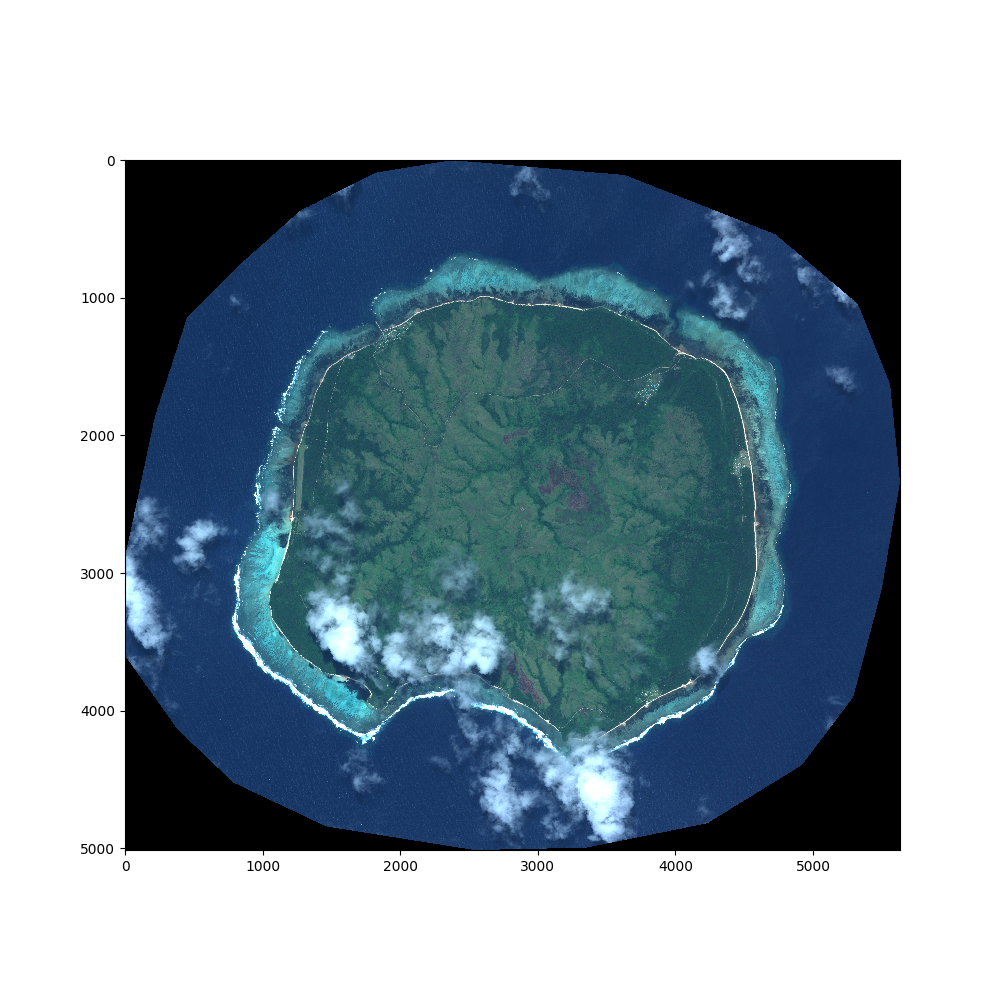

<IPython.core.display.Javascript object>


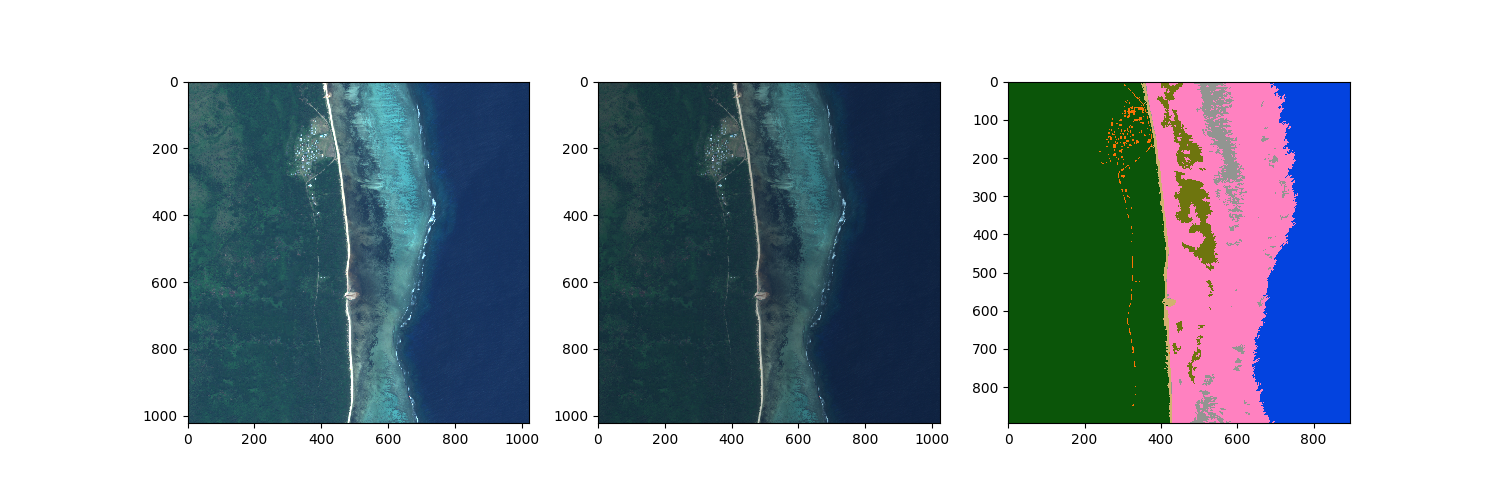

<IPython.core.display.Javascript object>


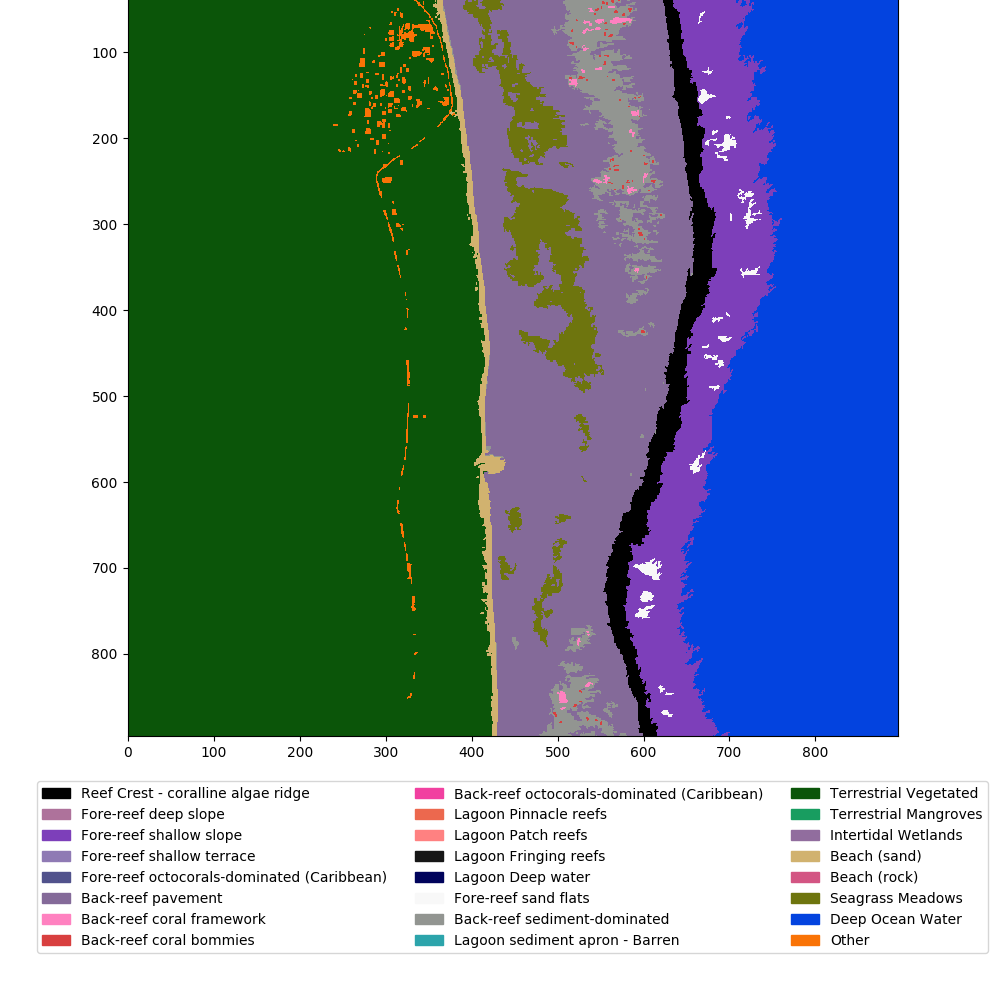

In [85]:
cmap_24classes = colors.ListedColormap(['xkcd:black', '#ae729b', '#7d3fba', '#8f7ab4', '#51528c',
                             '#846a99', 'xkcd:pink', '#d83f3f', '#f140a0', '#ec684e', '#ff8181',
                             '#161616', 'xkcd:dark blue', '#f8f8f8', 'xkcd:grey', '#2ca4ab',
                             'xkcd:forest', '#189d60', '#916d9e', 'xkcd:tan',
                             '#d35583', 'xkcd:olive', 'xkcd:blue', 'xkcd:orange'])
bounds_24classes = [i+0.5 for i in range(25)]
norm_24classes = colors.BoundaryNorm([b+0.5 for b in bounds_24classes], cmap_24classes.N)

cmap_Ved = colors.ListedColormap(['xkcd:pink', 'xkcd:grey', 'xkcd:tan', 'xkcd:olive', 'xkcd:forest', 'xkcd:blue',
                                'xkcd:lilac', 'xkcd:cyan', 'xkcd:orange'])
bounds = [i+0.5 for i in range(10)]
norm = colors.BoundaryNorm([b+0.5 for b in bounds], cmap_Ved.N)

xstart = 4100
xlen = 1024
ystart = 2000
ylen = 1024

# xstart = 2000
# xlen = 1024
# ystart = 4500
# ylen = 1024

predict_size = 128

Fiji.testimage = Fiji.image[ystart:ystart+ylen,xstart:xstart+xlen,:]
Fiji.testimage = np.delete(Fiji.testimage, [0,3,5,7], 2) # harded coded for BGR + NIR
# Fiji.testimage[:,:,0] = Fiji.testimage[:,:,0]-8 # some corrections
# Fiji.testimage[:,:,1] = Fiji.testimage[:,:,1]-9
# Fiji.testimage[:,:,2] = Fiji.testimage[:,:,2]

crop_len = int(np.floor(x/2))
offstart = crop_len-int(np.floor(predict_size/2))
Testtruth = FijiTruth_Ved[ystart+offstart:ystart+ylen-offstart,xstart+offstart:xstart+xlen-offstart]
Testtruth_24classes = FijiTruth_24classes[ystart+offstart:ystart+ylen-offstart,xstart+offstart:xstart+xlen-offstart]
Testtruth_Major = FijiTruth_Major[ystart+offstart:ystart+ylen-offstart,xstart+offstart:xstart+xlen-offstart]

patch_R = 255/200*Fiji.image[:,:,4]
patch_G = 255/200*Fiji.image[:,:,2]
patch_B = 255/200*Fiji.image[:,:,1]
patch_R[patch_R > 255] = 255
patch_G[patch_G > 255] = 255
patch_B[patch_B > 255] = 255
Fiji_RGB = np.rollaxis(np.asarray([patch_R, patch_G, patch_B], dtype=np.uint8),0,3)
# Fiji_RGB = np.rollaxis(np.asarray([1/max_R*Fiji.image[:,:,2], 1/max_G*Fiji.image[:,:,1], 1/max_B*Fiji.image[:,:,0]]),0,3)
# print(np.unique(Testtruth))

fig = plt.figure(1,figsize=(10,10))
plt.imshow(Fiji_RGB)

fig = plt.figure(2,figsize=(15,5))
ax = plt.subplot(131)
ax.imshow(Fiji_RGB[ystart:ystart+ylen,xstart:xstart+xlen,:])

patch_R = 255/300*Fiji.testimage[:,:,2]
patch_G = 255/300*Fiji.testimage[:,:,1]
patch_B = 255/300*Fiji.testimage[:,:,0]
patch_R[patch_R > 255] = 255
patch_G[patch_G > 255] = 255
patch_B[patch_B > 255] = 255
ax = plt.subplot(132)
ax.imshow(np.rollaxis(np.asarray([patch_R, patch_G, patch_B], dtype=np.uint8),0,3))

ax = plt.subplot(133)
ax.imshow(Testtruth.astype(int), interpolation='nearest', cmap=cmap_Ved, norm=norm)
# box = ax.get_position()
# ax.set_position([box.x0, box.y0 + box.height * 0.2, box.width, box.height])
# ax.legend([mpatches.Patch(color=cmap_Ved(i)) for i in range(len(cmap_Ved.colors))],
#            ['{}'.format(class_indices_rev[i+1]) for i in range(len(class_indices_rev))],
#           loc='upper center', bbox_to_anchor=(0.5,-0.05), ncol=3)

fig = plt.figure(3,figsize=(10,10))
ax = plt.subplot(111)
ax.imshow(Testtruth_24classes.astype(int), interpolation='nearest', cmap=cmap_24classes, norm=norm_24classes)
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.2, box.width, box.height])
ax.legend([mpatches.Patch(color=cmap_24classes(i)) for i in range(len(cmap_24classes.colors))],
           ['{}'.format(class_indices_rev_24classes[i+1]) for i in range(len(class_indices_rev_24classes))],
          loc='upper center', bbox_to_anchor=(0.5,-0.05), ncol=3)

plt.show()

# print(Fiji.truthimage[250,50])

{1: 'Coral', 2: 'Sediment', 3: 'Beach', 4: 'Seagrass', 5: 'Terrestrial vegetation', 6: 'Deep water', 7: 'Clouds', 8: 'Wave breaking', 9: 'Other or Unknown'}
Line: 0 Col: 0/ 769 completed
Line: 0 Col: 128/ 769 completed
Line: 0 Col: 256/ 769 completed
Line: 0 Col: 384/ 769 completed
Line: 0 Col: 512/ 769 completed
Line: 0 Col: 640/ 769 completed
Line: 0 Col: 768/ 769 completed
Line: 128 Col: 0/ 769 completed
Line: 128 Col: 128/ 769 completed
Line: 128 Col: 256/ 769 completed
Line: 128 Col: 384/ 769 completed
Line: 128 Col: 512/ 769 completed
Line: 128 Col: 640/ 769 completed
Line: 128 Col: 768/ 769 completed
Line: 256 Col: 0/ 769 completed
Line: 256 Col: 128/ 769 completed
Line: 256 Col: 256/ 769 completed
Line: 256 Col: 384/ 769 completed
Line: 256 Col: 512/ 769 completed
Line: 256 Col: 640/ 769 completed
Line: 256 Col: 768/ 769 completed
Line: 384 Col: 0/ 769 completed
Line: 384 Col: 128/ 769 completed
Line: 384 Col: 256/ 769 completed
Line: 384 Col: 384/ 769 completed
Line: 384 Col: 

<IPython.core.display.Javascript object>


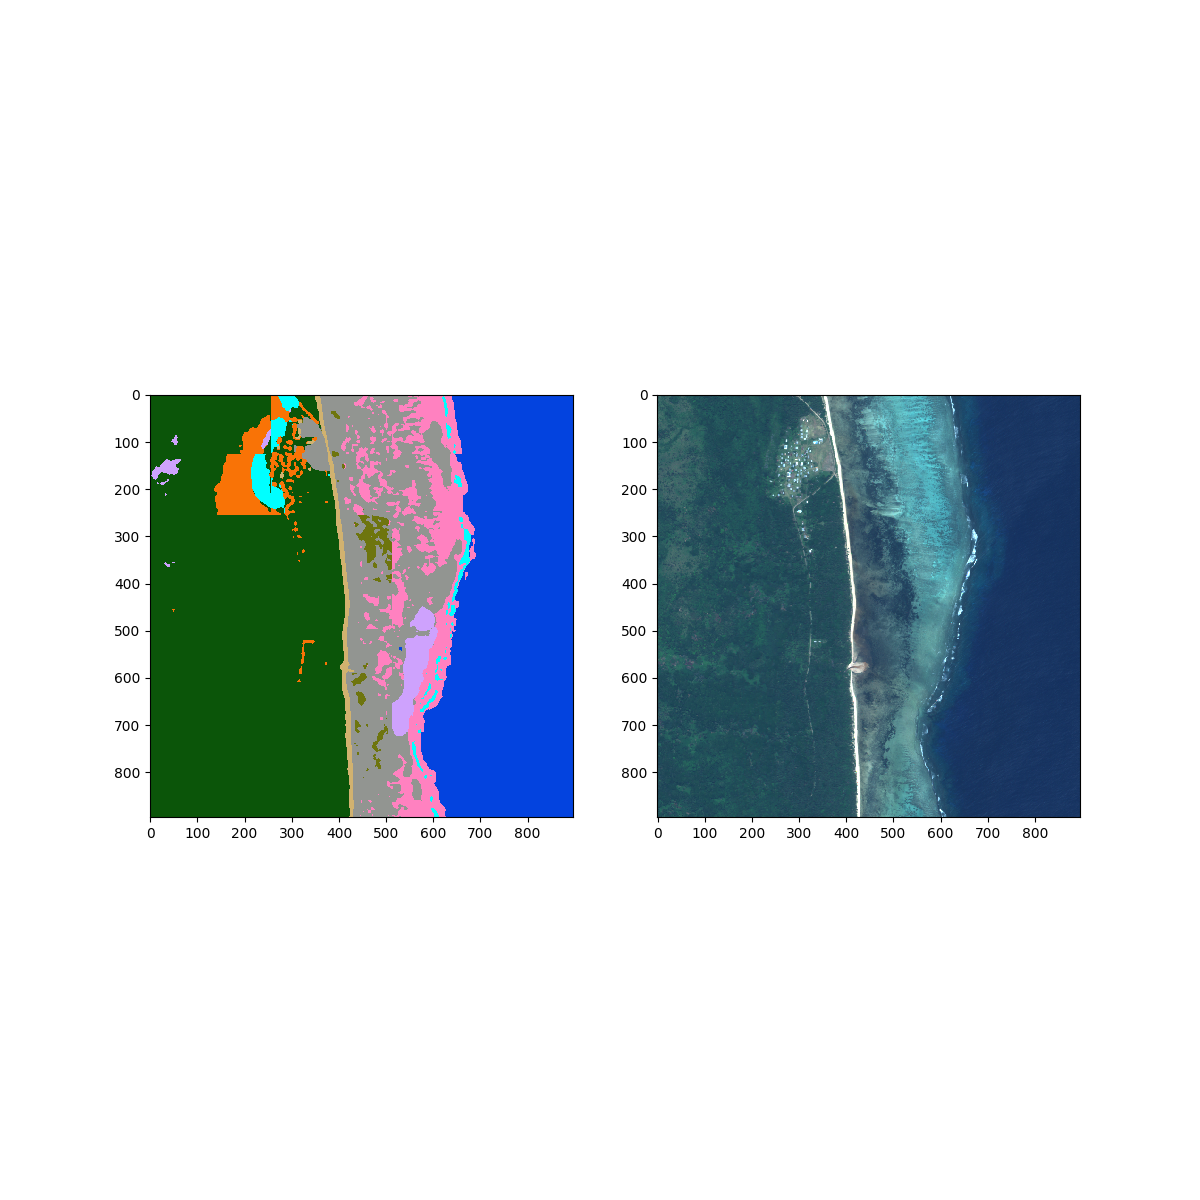

In [86]:
# PREDICTION TIME!

class_indices_rev = dict((v,k) for k,v in labelkey.items()) #flip k,v
print(class_indices_rev)

# smallimgx = 200
# smallimgy = 675
# smalltestimg = Fiji.image[ystart+smallimgy:ystart+smallimgy+256,xstart+smallimgx:xstart+smallimgx+256,:]
# smalltestimg = np.delete(smalltestimg, [0,3,5,7], 2) # harded coded for BGR + NIR
# Fiji.testimage = smalltestimg

Fiji.set_mean_std(100,100)
whole_predict, num_predict, prob_predict, truth_predict, accuracy = \
    Fiji.predict_on_whole_image(model, image_size = 256, num_classes = len(class_indices_rev), spacing = (128,128), predict_size = 128, num_lines=None, lastchannelremove=False)

fig = plt.figure(10,figsize=(12,12))
# ax = plt.subplot(121)
# patch_R = 255/200*smalltestimg[:,:,2]
# patch_G = 255/200*smalltestimg[:,:,1]
# patch_B = 255/200*smalltestimg[:,:,0]
# patch_R[patch_R > 255] = 255
# patch_G[patch_G > 255] = 255
# patch_B[patch_B > 255] = 255
# smalltestimg_RGB = np.rollaxis(np.asarray([patch_R, patch_G, patch_B], dtype=np.uint8),0,3)
# plt.imshow(smalltestimg_RGB)

ax = plt.subplot(121)
ax.imshow(whole_predict.astype(int)+1, interpolation='nearest', cmap=cmap_Ved, norm=norm)

ax = plt.subplot(122)
plt.imshow(Fiji_RGB[ystart+offstart:ystart+ylen-offstart,xstart+offstart:xstart+xlen-offstart,:])
plt.show()


<IPython.core.display.Javascript object>


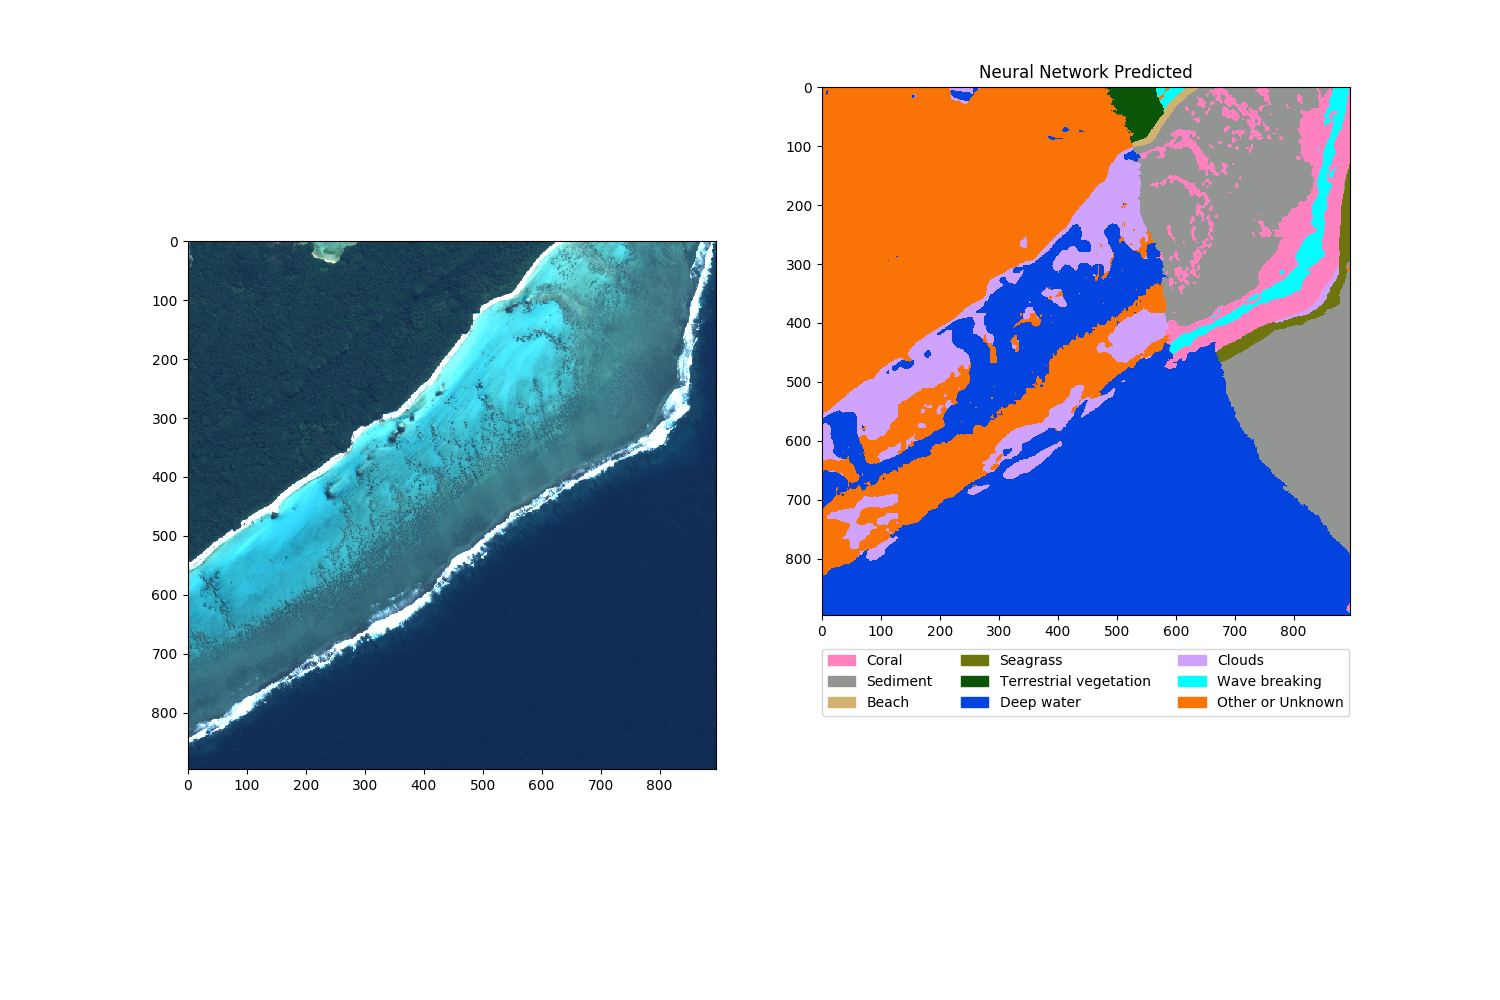

In [16]:
def MajorMask(predict_img, mask_img, prob_img, predict_labelkey, mask_labelkey):
    land = np.reshape((mask_img == mask_labelkey['Terrestrial']), (-1))
    water = np.reshape((mask_img == mask_labelkey['Deep water']), (-1))
    shallows = np.reshape((mask_img == mask_labelkey['Shallows']), (-1))
    
    original_shape = predict_img.shape
    original_prob_shape = prob_img.shape
    predict_reshape = np.reshape(np.copy(predict_img), (-1))
    prob_reshape = np.reshape(np.copy(prob_img),(-1,9))
    
    for i in range(len(predict_reshape)):
        if (land[i] == True):
            idx = 7
            sorted_idx = np.argsort(prob_reshape[i])
            while (predict_reshape[i] != predict_labelkey['Clouds']-1) and (predict_reshape[i] != predict_labelkey['Terrestrial vegetation']-1) and (predict_reshape[i] != predict_labelkey['Other or Unknown']-1):
                predict_reshape[i] = sorted_idx[idx]
                prob_reshape[i][sorted_idx[0:idx+1]] = prob_reshape[i][sorted_idx[0:idx+1]] + prob_reshape[i][sorted_idx[idx+1]]/(idx+1) #divide up probabilities amongst remaining
                prob_reshape[i][sorted_idx[idx+1]] = 0
                idx = idx-1
        elif (water[i] == True):
            idx = 7
            sorted_idx = np.argsort(prob_reshape[i])
            while (predict_reshape[i] != predict_labelkey['Clouds']-1) and (predict_reshape[i] != predict_labelkey['Deep water']-1) and (predict_reshape[i] != predict_labelkey['Other or Unknown']-1):
                predict_reshape[i] = sorted_idx[idx]
                prob_reshape[i][sorted_idx[0:idx+1]] = prob_reshape[i][sorted_idx[0:idx+1]] + prob_reshape[i][sorted_idx[idx+1]]/(idx+1)
                prob_reshape[i][sorted_idx[idx+1]] = 0
                idx = idx-1
        elif (shallows[i] == True):
            idx = 7
            sorted_idx = np.argsort(prob_reshape[i])
            while (predict_reshape[i] == predict_labelkey['Terrestrial vegetation']-1) or (predict_reshape[i] == predict_labelkey['Deep water']-1):
                predict_reshape[i] = sorted_idx[idx]
                prob_reshape[i][sorted_idx[0:idx+1]] = prob_reshape[i][sorted_idx[0:idx+1]] + prob_reshape[i][sorted_idx[idx+1]]/(idx+1)
                prob_reshape[i][sorted_idx[idx+1]] = 0
                idx = idx-1
    
    return np.reshape(predict_reshape, original_shape), np.reshape(prob_reshape, original_prob_shape)
                
cmap_Ved = colors.ListedColormap(['xkcd:pink', 'xkcd:grey', 'xkcd:tan', 'xkcd:olive', 'xkcd:forest', 'xkcd:blue',
                                'xkcd:lilac', 'xkcd:cyan', 'xkcd:orange'])
bounds = [i-0.5 for i in range(len(cmap_Ved.colors)+1)] # assumes labels start at 0
norm = colors.BoundaryNorm([b+0.5 for b in bounds], cmap_Ved.N)


whole_predict_mask, whole_predict_mask_prob = MajorMask(whole_predict, Testtruth_Major, prob_predict, json_data["VedConsolidated_ClassDict"], json_data["MajorConsolidated_ClassDict"])
# prob_predict_img = np.argmax(prob_predict,axis=2)
# prob_predict_img_mask, prob_predict_img_mask_prob = MajorMask(prob_predict_img, Testtruth_Major, prob_predict, json_data["VedConsolidated_ClassDict"], json_data["MajorConsolidated_ClassDict"])

patch_R = 255/200*Fiji.image[:,:,4]
patch_G = 255/200*Fiji.image[:,:,2]
patch_B = 255/200*Fiji.image[:,:,1]
patch_R[patch_R > 255] = 255
patch_G[patch_G > 255] = 255
patch_B[patch_B > 255] = 255
Fiji_RGB = np.rollaxis(np.asarray([patch_R, patch_G, patch_B], dtype=np.uint8),0,3)
fig = plt.figure(4,figsize=(15,10))
ax = plt.subplot(121)
ax.imshow(Fiji_RGB[ystart+offstart:ystart+ylen-offstart,xstart+offstart:xstart+xlen-offstart])

ax = plt.subplot(122)
ax.imshow(whole_predict_mask, interpolation='nearest', cmap=cmap_Ved, norm=norm)
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.2, box.width, box.height])
ax.legend([mpatches.Patch(color=cmap_Ved(i)) for i in range(len(cmap_Ved.colors))],
           ['{}'.format(class_indices_rev[i+1]) for i in range(len(class_indices_rev))],
          loc='upper center', bbox_to_anchor=(0.5,-0.05), ncol=3)

# ax.legend([mpatches.Patch(color=cmap_Ved(i)) for i in range(24)], ['{}'.format(class_indices_rev[k]) for k in class_indices_rev], loc='upper center', bbox_to_anchor=(0.5,-0.05), ncol=2)
# ax.set_axis_off()
ax.set_title('Neural Network Predicted')
plt.show()


# fig = plt.figure(3,figsize=(10,10))
# ax = plt.subplot(111)
# ax.imshow(Testtruth-1, interpolation='nearest', cmap=cmap_Ved, norm=norm)
# box = ax.get_position()
# ax.set_position([box.x0, box.y0 + box.height * 0.2,
#                  box.width, box.height])
# # ax.legend([mpatches.Patch(color=cmap_Ved(i)) for i in range(24)],
# #               ['{}'.format(class_indices_rev[k]) for k in class_indices_rev],
# #               loc='upper center', bbox_to_anchor=(0.5,-0.05), ncol=2)
# ax.legend([mpatches.Patch(color=cmap_Ved(i)) for i in range(len(cmap_Ved.colors))],
#            ['{}'.format(class_indices_rev[i+1]) for i in range(len(class_indices_rev))],
#           loc='upper center', bbox_to_anchor=(0.5,-0.05), ncol=3)
# ax.set_title('ECognition Predicted')
# # ax.set_axis_off()
# # fig.savefig('Ecognition_Reference.png', bbox_inches='tight')
# plt.show()

In [25]:
print(prob_predict[100,0])
print(offstart)

[7.96664317e-05 1.95433779e-04 4.65994031e-04 2.47342214e-05
 9.95742261e-01 1.70165658e-05 1.62140233e-04 2.01919046e-03
 1.29351160e-03]
64


In [87]:
# Conditional random field code
import pydensecrf.densecrf as dcrf
from cv2 import imread, imwrite
from pydensecrf.utils import unary_from_labels, create_pairwise_bilateral, create_pairwise_gaussian, unary_from_softmax

prob_predict_switch = np.rollaxis(prob_predict,2,0)
U = unary_from_softmax(prob_predict_switch)
d = dcrf.DenseCRF2D(xlen-2*offstart, ylen-2*offstart,len(class_indices_rev))
d.setUnaryEnergy(U)
pairwise_gaussian = create_pairwise_gaussian(sdims=(5,5), shape=whole_predict.shape[:2]) # smaller the sdims, the more important it is
d.addPairwiseEnergy(pairwise_gaussian, compat=0, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)
pairwise_bilateral = create_pairwise_bilateral(sdims=(10,10), schan=3, img=Fiji.testimage[offstart:xlen-offstart,offstart:ylen-offstart], chdim=2) 
d.addPairwiseEnergy(pairwise_bilateral, compat=10, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)

Q, tmp1, tmp2 = d.startInference()
for i in range(20):
    print("KL-divergence at {}: {}".format(i, d.klDivergence(Q)))
    d.stepInference(Q, tmp1, tmp2)

KL-divergence at 0: -6416262.240828044
KL-divergence at 1: -7323796.6189651955
KL-divergence at 2: -7482720.691863223
KL-divergence at 3: -7517873.037598453
KL-divergence at 4: -7531575.6549937995
KL-divergence at 5: -7539693.0227457285
KL-divergence at 6: -7544618.8830532
KL-divergence at 7: -7548018.4223242635
KL-divergence at 8: -7550483.854421841
KL-divergence at 9: -7552384.829185057
KL-divergence at 10: -7553959.420142054
KL-divergence at 11: -7555298.927353653
KL-divergence at 12: -7556410.132855984
KL-divergence at 13: -7557364.885811008
KL-divergence at 14: -7558275.372765838
KL-divergence at 15: -7559278.595610605
KL-divergence at 16: -7560409.517713632
KL-divergence at 17: -7561467.632949385
KL-divergence at 18: -7562233.138455026
KL-divergence at 19: -7562890.306373058


<IPython.core.display.Javascript object>


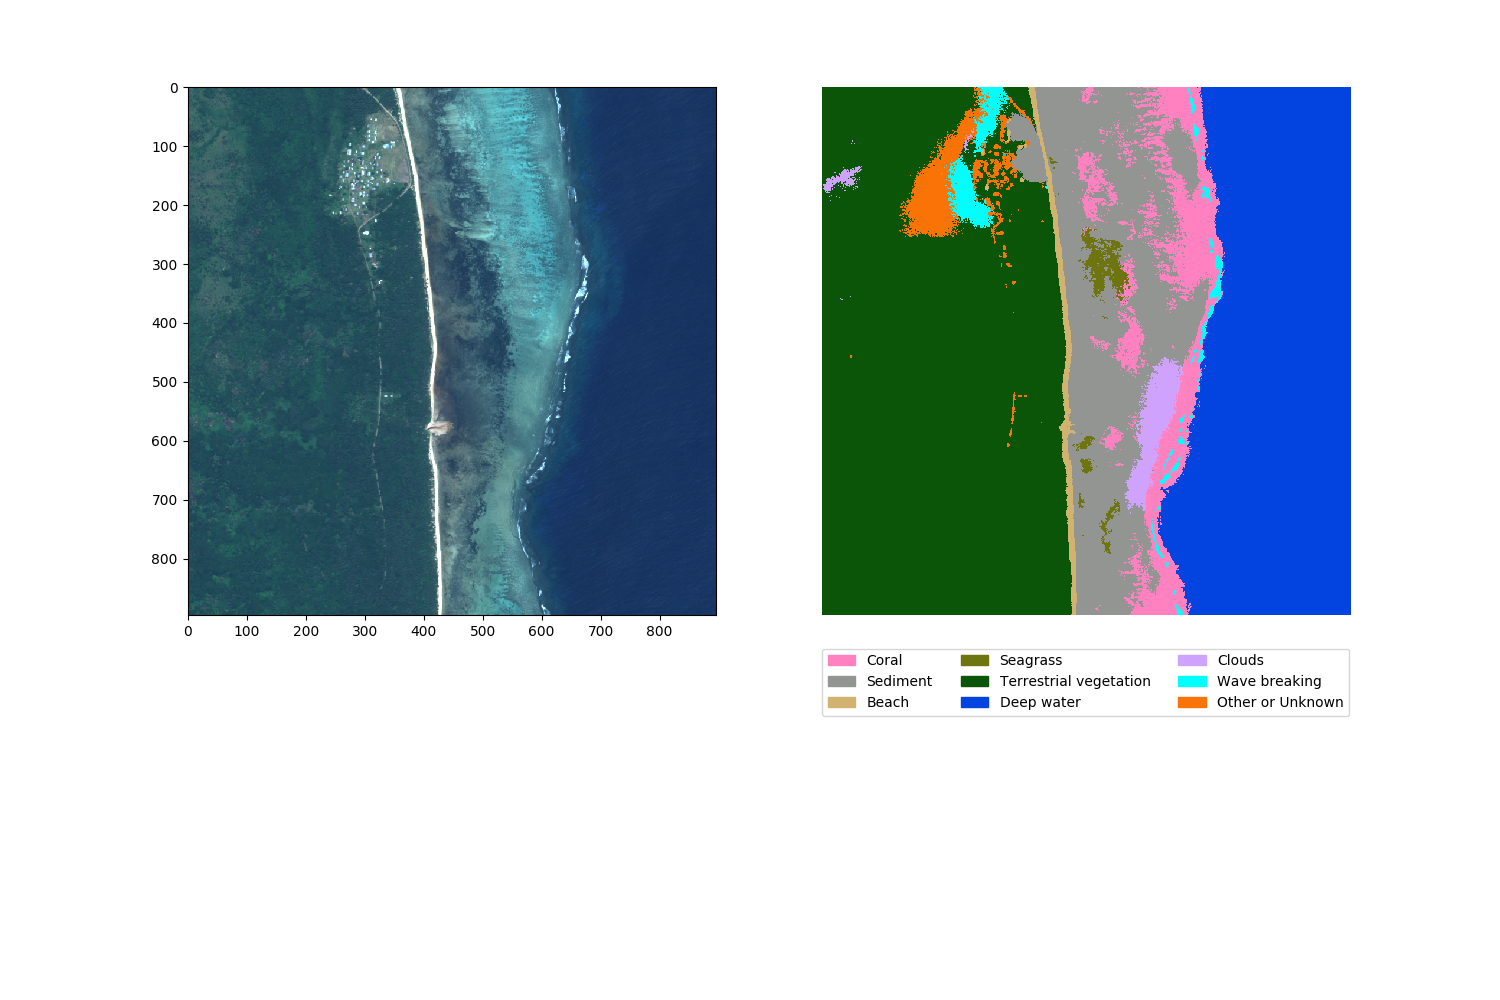

In [88]:
MAP = np.argmax(Q, axis=0)
final_predict = np.reshape(MAP, (ylen-2*offstart, xlen-2*offstart))
# accuracy = 100*np.asarray((final_predict == Testtruth_consolidated)).astype(np.float32).sum()/(whole_predict.shape[0]*whole_predict.shape[1])
# print(accuracy)

fig = plt.figure(6,figsize=(15,10))
ax = plt.subplot(121)
ax.imshow(Fiji_RGB[ystart+offstart:ystart+ylen-offstart,xstart+offstart:xstart+xlen-offstart])
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.2, box.width, box.height])

ax = plt.subplot(122)
ax.imshow(final_predict.astype(int)+1, interpolation='nearest', cmap=cmap_Ved, norm=norm)
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.2, box.width, box.height])
ax.legend([mpatches.Patch(color=cmap_Ved(i)) for i in range(len(cmap_Ved.colors))],
           ['{}'.format(class_indices_rev[i+1]) for i in range(len(class_indices_rev))],
          loc='upper center', bbox_to_anchor=(0.5,-0.05), ncol=3)
ax.set_axis_off()
plt.show()

{'Coral': 1, 'Sediment': 2, 'Beach': 3, 'Seagrass': 4, 'Terrestrial vegetation': 5, 'Deep water': 6, 'Clouds': 7, 'Wave breaking': 8, 'Other or Unknown': 9}
[128.4076799  119.83850319  63.97941544  12.10852242]
[ 94.13612331  85.94180416  50.4381927  116.89582212]
[97.27675335 91.3401053  73.63962873 51.65826527]


<IPython.core.display.Javascript object>


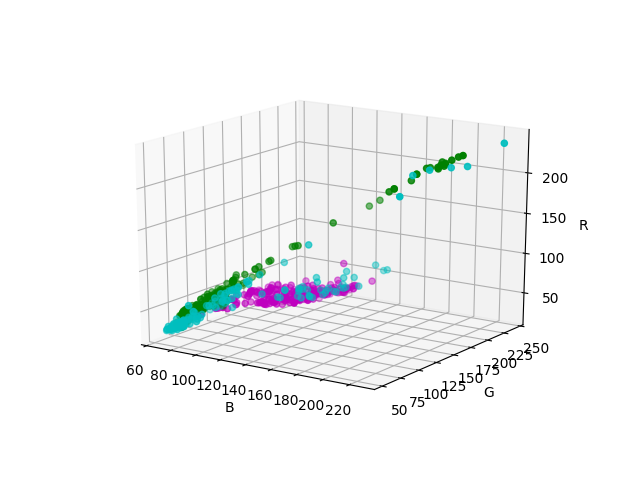

<IPython.core.display.Javascript object>


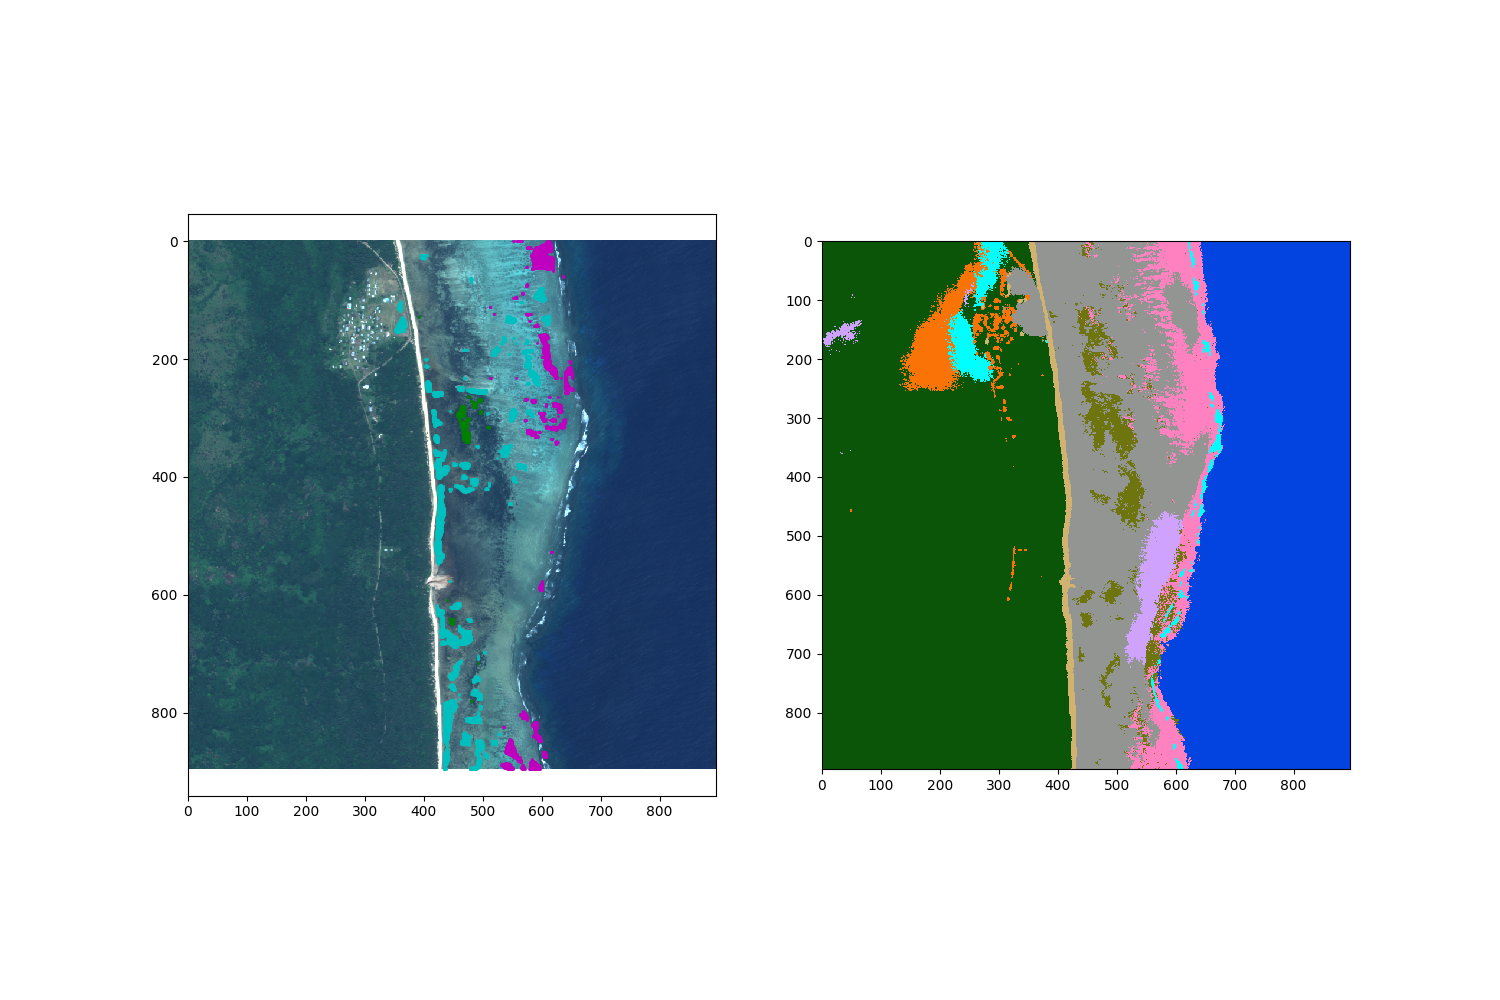

In [134]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn import svm
# There is still confusion between coral and sediment to a degree... we can fine tune it
print(labelkey)
n=200
corals = np.where(final_predict.astype(int)+1 == labelkey['Coral'])
corals_highprob = np.where(prob_predict[:,:,0] >= 0.95)
randomcorals = np.random.randint(len(corals_highprob[0]), size=n)
randomcorals = Fiji.testimage[corals_highprob[0][randomcorals],corals_highprob[1][randomcorals],:]

sediment = np.where(final_predict.astype(int)+1 == labelkey['Sediment'])
sediment_highprob = np.where(prob_predict[:,:,1] >= 0.95)
randomsed = np.random.randint(len(sediment_highprob[0]), size=n)
randomsed = Fiji.testimage[sediment_highprob[0][randomsed],sediment_highprob[1][randomsed],:]

seagrass = np.where(final_predict.astype(int)+1 == labelkey['Seagrass'])
seagrass_highprob = np.where(prob_predict[:,:,3] >= 0.9)
randomsg = np.random.randint(len(seagrass_highprob[0]), size=n)
randomsg = Fiji.testimage[seagrass_highprob[0][randomsg],seagrass_highprob[1][randomsg],:]

print(np.mean(randomcorals,0))
print(np.mean(randomsed,0))
print(np.mean(randomsg,0))

combineX = np.concatenate((randomcorals,randomsg), axis=0)
kmeans = KMeans(n_clusters=2).fit(combineX)
y = np.concatenate((np.zeros(n,), np.ones(n,)), axis=0)
clf = svm.SVC(gamma=0.01)
clf.fit(combineX,y)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(randomcorals[:,0], randomcorals[:,1], randomcorals[:,2], c='m',marker='o')
ax.scatter(randomsed[:,0], randomsed[:,1], randomsed[:,2], c='c',marker='o')
ax.scatter(randomsg[:,0], randomsg[:,1], randomsg[:,2], c='g',marker='o')
ax.set_xlabel('B')
ax.set_ylabel('G')
ax.set_zlabel('R')
plt.show()



# if np.linalg.norm(kmeans.cluster_centers_[0]) > np.linalg.norm(kmeans.cluster_centers_[1]):
#     coralidx = 0
#     sedimentidx = 1
# else:
#     coralidx = 1
#     sedimentidx = 0

# totalcorals = Fiji.testimage[corals[0][:], corals[1][:], :]
# totalcorals_predict = kmeans.predict(totalcorals)
# totalsediment = Fiji.testimage[sediment[0][:], sediment[1][:], :]
# totalsediment_predict = kmeans.predict(totalsediment)
# kmeans_predict = np.copy(final_predict)
# for i in range(len(corals[0])):
#     if totalcorals_predict[i]:
#         kmeans_predict[corals[0][i],corals[1][i]] = coralidx
#     else:
#         kmeans_predict[corals[0][i],corals[1][i]] = sedimentidx
# for i in range(len(sediment[0])):
#     if totalsediment_predict[i]:
#         kmeans_predict[sediment[0][i],sediment[1][i]] = coralidx
#     else:
#         kmeans_predict[sediment[0][i],sediment[1][i]] = sedimentidx
        
coralidx = 0
seagrassidx = 3

totalcorals = Fiji.testimage[corals[0][:], corals[1][:], :]
totalcorals_predict = clf.predict(totalcorals)  
totalsg = Fiji.testimage[seagrass[0][:], seagrass[1][:], :]
totalsg_predict = clf.predict(totalsg)
totalsediment = Fiji.testimage[sediment[0][:], sediment[1][:], :]
totalsediment_predict = clf.predict(totalsediment)
kmeans_predict = np.copy(final_predict)
for i in range(len(corals[0])):
    if totalcorals_predict[i] == 0:
        kmeans_predict[corals[0][i],corals[1][i]] = coralidx
    else:
        kmeans_predict[corals[0][i],corals[1][i]] = seagrassidx
    
    
fig = plt.figure(12,figsize=(15,10))
ax = plt.subplot(121)
ax.imshow(Fiji_RGB[ystart+offstart:ystart+ylen-offstart,xstart+offstart:xstart+xlen-offstart])
ax.scatter(y=corals_highprob[0], x=corals_highprob[1], c='m', s=1)
ax.scatter(y=sediment_highprob[0], x=sediment_highprob[1], c='c', s=1)
ax.scatter(y=seagrass_highprob[0], x=seagrass_highprob[1], c='g', s=1)

ax = plt.subplot(122)
ax.imshow(kmeans_predict.astype(int)+1, interpolation='nearest', cmap=cmap_Ved, norm=norm)
plt.show()

In [28]:
print(whole_predict_mask[436,335])

6.0
